# ICON Stencil
This stencil is based on `model/atmosphere/dycore/src/icon4py/model/atmosphere/dycore/mo_velocity_advection_stencil_20.py`.
It is very simple and most faithfull implementation.

A reference `NumPy` implementation can be found in `model/atmosphere/dycore/tests/stencil_tests/test_mo_velocity_advection_stencil_20.py`.


In [1]:
import os, copy
#ncpu=1
#os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={ncpu}"
#os.environ["XLA_FLAGS"] = ("--xla_cpu_multi_thread_eigen=false " "intra_op_parallelism_threads=1")
#os.environ['JAX_PLATFORMS'] = "cpu"

from datetime import datetime
from pickle import load

import numpy as np
import jax
import sys
import jax.numpy as jnp
from jax import jit, grad, vmap
from jax import random

# This must be enabled when `make_jaxpr` is called, because otherwhise we get problems.
jax.config.update("jax_enable_x64", True)

import dace


In [2]:
ToOpen = "runtime_data/ICON_CPU__2023-12-11_12-58-53.pickle"
with open(ToOpen, '+br') as F:
    KDimNs, resTime_itir, resTime_jax, resTime_sdfg = load(F)
#

In [3]:
resTime_sdfg_min = np.array([r.min()  for r in resTime_sdfg])
resTime_jax_min = np.array([r.min()  for r in resTime_jax])
resTime_itir_min = np.array([r.min()  for r in resTime_itir])

resTime_sdfg_mean = np.array([r.mean()  for r in resTime_sdfg])
resTime_jax_mean = np.array([r.mean()  for r in resTime_jax])
resTime_itir_mean = np.array([r.mean()  for r in resTime_itir])

resTime_sdfg_std = np.array([r.std()  for r in resTime_sdfg])
resTime_jax_std = np.array([r.std()  for r in resTime_jax])
resTime_itir_std = np.array([r.std()  for r in resTime_itir])


In [4]:
repeat, number = 3000, 50

In [5]:
import matplotlib as mpl
from matplotlib import pyplot as plt

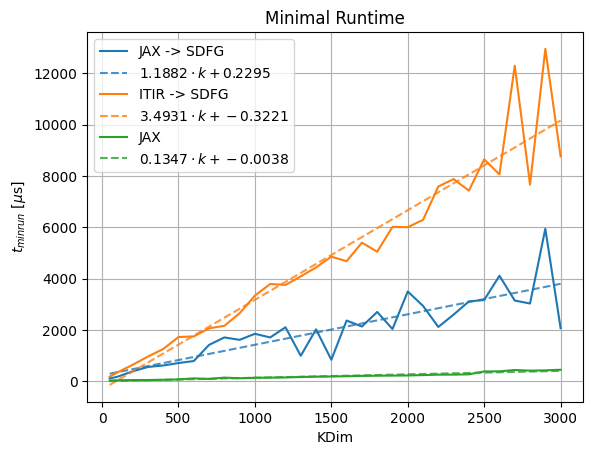

In [6]:
X = np.vstack([KDimNs, np.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, Time * 1000000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(KDimNs) + b
    plt.plot(
        KDimNs, Times_ * 1000000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e6*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )
#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$t_{min run}$ [$\\mu$s]')
plt.grid(visible=True)
#plt.yscale('log')

plt.title("Minimal Runtime")

plt.show()


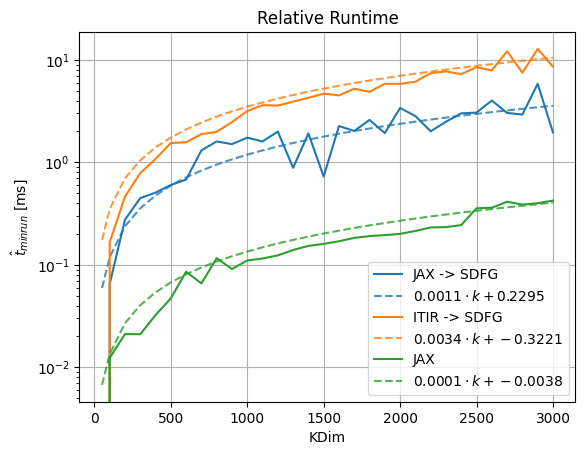

In [7]:
X = np.vstack([KDimNs, np.ones_like(KDimNs)]).T

for ID, Time in {'JAX -> SDFG':  resTime_sdfg_min,
                 'ITIR -> SDFG': resTime_itir_min,
                 'JAX':          resTime_jax_min, }.items():
    plt.plot(KDimNs, (Time - Time[0]) * 1000 / number, label=ID)
    col = plt.gca().lines[-1].get_color()
    a, b = np.linalg.lstsq(X, Time / number, rcond=None)[0]

    Times_ = a * np.array(KDimNs)
    plt.plot(
        KDimNs, Times_ * 1000,
        c=col, linestyle='--', alpha=0.8, 
        label=f'${int(a * (1e3*1e4))/1e4} \\cdot k + {int(b * (1e3*1e4))/1e4}$',
    )

#


plt.legend()
plt.xlabel('KDim')
plt.ylabel('$\\hat{t}_{min run}$ [ms]')
plt.grid(visible=True)
plt.yscale('log')

plt.title("Relative Runtime")

plt.show()
